In [15]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal.windows import gaussian
from scipy.ndimage import gaussian_filter

In [2]:
y, sr = librosa.load(librosa.example("libri1"), sr=None)

In [11]:
suby = y[2000:6000]

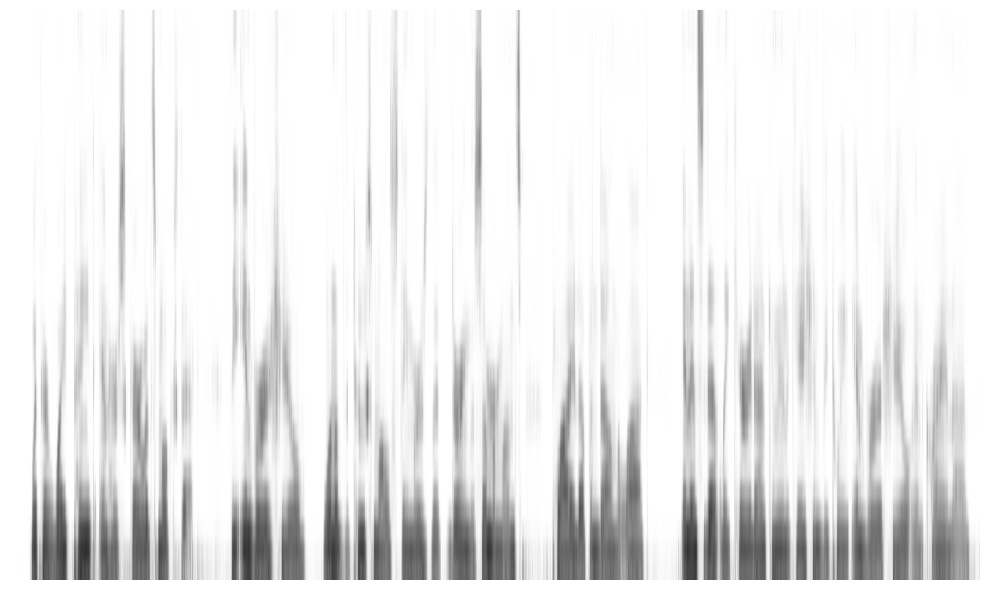

In [18]:
window_length = int(0.005 * sr)  # ~5 ms window length
hop_length = int(0.001 * sr)    # ~1 ms hop length for good time resolution
n_fft = int(2 ** np.ceil(np.log2(window_length)))  # FFT size matching window length

# Generate Gaussian window
gaussian_window = gaussian(window_length, std=window_length / 6)

# Compute STFT with Gaussian window
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=window_length, window=gaussian_window)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Apply dynamic range cutoff
dynamic_range = 50  # Praat's dynamic range
S_db = np.clip(S_db, a_min=S_db.max() - dynamic_range, a_max=None)

# Frequency range (e.g., 0 to 5000 Hz for speech analysis)
max_freq = 5000  # in Hz
max_bin = int(max_freq / (sr / n_fft))

# Plot in grayscale with no interpolation
plt.figure(figsize=(10, 6))
plt.imshow(
    S_db[:max_bin, :], aspect="auto", origin="lower", cmap="Greys",
    extent=[0, len(y) / sr, 0, max_freq]  # No interpolation
)
plt.axis("off")  # Hide axes for a clean display
plt.tight_layout()
plt.show()

In [ ]:
!sudo apt update
!sudo apt install libcairo2-dev \
    texlive texlive-latex-extra texlive-fonts-extra \
    texlive-latex-recommended texlive-science \
    tipa libpango1.0-dev
!pip install manim

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [62.7 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,285 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,620 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu 

In [ ]:
from manim import *
import numpy as np
import librosa

In [ ]:
%%manim -qm -v WARNING MovingWindowAnalysis

class MovingWindowAnalysis(Scene):
    def construct(self):
        # Load audio signal
        y, sr = librosa.load(librosa.example("trumpet"), sr=None)  # Load example audio
        start_sample = 0  # Starting sample for the visualization
        end_sample = 4000  # Ending sample for visualization
        y = y[start_sample:end_sample]

        # Parameters for the sliding window
        window_length = 512
        hop_length = 128  # How much the window moves each frame
        hamming_window = np.hamming(window_length)
        num_frames = (len(y) - window_length) // hop_length

        # Generate time and signal axes
        signal_axis = np.linspace(0, len(y) / sr, len(y))
        freq_axis = np.fft.rfftfreq(window_length, 1 / sr)

        # Create axes for signal
        signal_axes = Axes(
            x_range=[0, len(y) / sr, len(y) / sr / 10],
            y_range=[-0.5, 0.5, 0.1],
            x_length=10,
            y_length=2,
            axis_config={"include_numbers": True},
            tips=False
        ).shift(UP * 2)

        signal_graph = signal_axes.plot_line_graph(
            x_values=signal_axis,
            y_values=y,
            line_color=BLUE
        )

        # Create axes for FFT
        fft_axes = Axes(
            x_range=[0, 8000, 1000],
            y_range=[-70, 30, 10],
            x_length=10,
            y_length=2,
            axis_config={"include_numbers": True},
            tips=False
        ).shift(DOWN * 2)

        fft_graph = fft_axes.plot_line_graph(
            x_values=[],
            y_values=[],
            line_color=GREEN
        )

        # Create moving window highlight
        window_highlight = signal_axes.get_vertical_line(
            x=0, line_config={"color": RED, "stroke_width": 2}
        ).set_width(window_length / len(y) * signal_axes.x_length)

        # Add all components to the scene
        self.add(signal_axes, fft_axes, signal_graph, fft_graph, window_highlight)

        # Animation
        def update_fft_and_window(frame):
            # Compute window start and end indices
            window_start = frame * hop_length
            window_end = window_start + window_length

            # Apply Hamming window to the segment
            segment = y[window_start:window_end] * hamming_window
            fft_result = np.fft.rfft(segment)
            fft_magnitude_db = 10 * np.log10(np.abs(fft_result) ** 2 + 1e-10)

            # Update FFT graph
            new_fft = fft_axes.plot_line_graph(
                x_values=freq_axis,
                y_values=fft_magnitude_db,
                line_color=GREEN
            )

            # Update window highlight position
            new_window_highlight = signal_axes.get_vertical_line(
                x=window_start / len(y) * signal_axes.x_range[1],
                line_config={"color": RED, "stroke_width": 2}
            ).set_width(window_length / len(y) * signal_axes.x_length)

            return new_fft, new_window_highlight

        # Animate the window moving and FFT updating
        for frame in range(num_frames):
            new_fft, new_window_highlight = update_fft_and_window(frame)
            self.play(
                Transform(fft_graph, new_fft),
                Transform(window_highlight, new_window_highlight),
                run_time=0.1
            )
